In [1]:
import os
import pickle
parent_dir = os.path.abspath(os.path.join(os.getcwd(), '..'))
if parent_dir not in sys.path:
    sys.path.append(parent_dir)

from preprocessing import downsample_word_vectors, make_delayed

# === Load raw_text.pkl (contains tokenized words for each story) ===
pkl_path = '/ocean/projects/mth240012p/shared/data/raw_text.pkl'
with open(pkl_path, 'rb') as f:
    raw_text = pickle.load(f)

In [2]:
import random
random.seed(42)
keys = list(raw_text.keys())
random.shuffle(keys)
train_keys = keys[:80]
test_keys = keys[80:]
train_data = {key: raw_text[key] for key in train_keys}
test_data = {key: raw_text[key] for key in test_keys}

In [3]:
train_texts = []
train_story_names = []
test_texts = []
test_story_names = []

for name, sequence in train_data.items():
    try:
        text = sequence.data
        text = ' '.join(text)
        train_texts.append(text)
        train_story_names.append(name)
    except Exception as e:
        print(f"Could not extract text for {name}: {e}")

for name, sequence in test_data.items():
    try:
        text = sequence.data
        text = ' '.join(text)
        test_texts.append(text)
        test_story_names.append(name)
    except Exception as e:
        print(f"Could not extract text for {name}: {e}")

In [4]:
# Chunk 1: Load pretrained Glove and prepare word-level matrix
import numpy as np
import gensim.downloader as api
from tqdm import tqdm

# Load small pretrained glove model
glove = api.load("glove-wiki-gigaword-100")
print(f"Loaded Glove with {len(glove.key_to_index)} words, vector size = {glove.vector_size}")

Loaded Glove with 400000 words, vector size = 100


In [5]:
os.chdir('../code')
import preprocessing as prep

delays = [1, 2, 3, 4]

# Paths
subject_dirs = [
    "/ocean/projects/mth240012p/shared/data/subject2",
    "/ocean/projects/mth240012p/shared/data/subject3"
]

In [6]:
train_glove_dic = {}
for name, ds in train_data.items():
    try:
        # Get word list
        word_list = ds.data.tolist() if isinstance(ds.data, np.ndarray) else ds.data
        vectors = []

        for word in word_list:
            if word in glove:
                vectors.append(glove[word])
            else:
                vectors.append(np.zeros(glove.vector_size))  # fallback if OOV

        word_matrix = np.stack(vectors)  # shape: (num_words, embedding_dim)

        # Downsample to TR resolution
        downsampled = prep.downsample_word_vectors(
            stories=[name],
            word_vectors={name: word_matrix},
            wordseqs={name: ds}
        )[name]

        # Trim 5s from start and 10s from end
        trimmed = downsampled[5 : -10, :]

        # Create delayed embedding
        delayed = prep.make_delayed(trimmed, delays)
        train_glove_dic[name] = delayed
    except Exception as e:
        print(f"ERROR processing {name}: {e}")

In [7]:
test_glove_dic = {}
for name, ds in test_data.items():
    try:
        # Get word list
        word_list = ds.data.tolist() if isinstance(ds.data, np.ndarray) else ds.data
        vectors = []

        for word in word_list:
            if word in glove:
                vectors.append(glove[word])
            else:
                vectors.append(np.zeros(glove.vector_size))  # fallback if OOV

        word_matrix = np.stack(vectors)  # shape: (num_words, embedding_dim)

        # Downsample to TR resolution
        downsampled = prep.downsample_word_vectors(
            stories=[name],
            word_vectors={name: word_matrix},
            wordseqs={name: ds}
        )[name]

        # Trim 5s from start and 10s from end
        trimmed = downsampled[5 : -10, :]

        # Create delayed embedding
        delayed = prep.make_delayed(trimmed, delays)
        test_glove_dic[name] = delayed
    except Exception as e:
        print(f"ERROR processing {name}: {e}")

In [8]:
print("Train story dimensions (TRs × features):")
for story_name, X in train_glove_dic.items():
    print(f"{story_name:25s} → {X.shape}")

Train story dimensions (TRs × features):
penpal                    → (255, 400)
hangtime                  → (324, 400)
thatthingonmyarm          → (434, 400)
theshower                 → (392, 400)
dialogue6                 → (325, 400)
haveyoumethimyet          → (496, 400)
souls                     → (355, 400)
undertheinfluence         → (304, 400)
cautioneating             → (279, 400)
superheroesjustforeachother → (325, 400)
wheretheressmoke          → (291, 400)
thetriangleshirtwaistconnection → (202, 400)
avatar                    → (367, 400)
gangstersandcookies       → (256, 400)
adventuresinsayingyes     → (391, 400)
fromboyhoodtofatherhood   → (348, 400)
gpsformylostidentity      → (326, 400)
becomingindian            → (388, 400)
theclosetthatateeverything → (314, 400)
thesurprisingthingilearnedsailingsoloaroundtheworld → (480, 400)
dialogue2                 → (329, 400)
adollshouse               → (241, 400)
escapingfromadirediagnosis → (343, 400)
quietfire                 


Evaluating subject2 using bootstrap_ridge
X_train: (25638, 400), Y_train: (25638, 94251)
X_test: (9148, 400), Y_test: (9148, 94251)
Running bootstrap_ridge...

Final Evaluation (subject2) — using selected valphas
Mean CC:    0.0124
Median CC:  0.0102
Top 1% CC:  0.0660
Top 5% CC:  0.0445


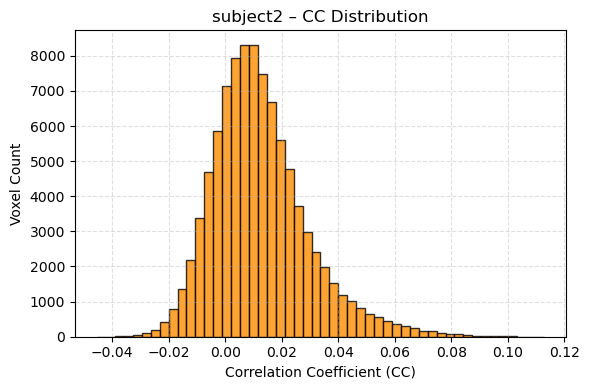


Evaluating subject3 using bootstrap_ridge
X_train: (25638, 400), Y_train: (25638, 95556)
X_test: (9148, 400), Y_test: (9148, 95556)
Running bootstrap_ridge...

Final Evaluation (subject3) — using selected valphas
Mean CC:    0.0189
Median CC:  0.0156
Top 1% CC:  0.0830
Top 5% CC:  0.0576


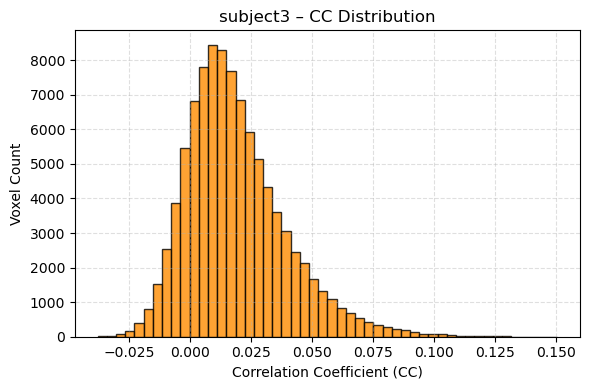

In [9]:
import os
import sys
import numpy as np
import matplotlib.pyplot as plt
from ridge_utils.ridge import bootstrap_ridge, zs

# === Setup ===
subject_dirs = {
    'subject2': '/ocean/projects/mth240012p/shared/data/subject2',
    'subject3': '/ocean/projects/mth240012p/shared/data/subject3'
}

alphas = np.logspace(0, 3, 5)
np.random.seed(42)

nboots = 15       # Number of bootstrap samples
chunklen = 10     # Chunk size for each held-out set
nchunks = 10      # How many chunks to hold out each time

for subject in ['subject2', 'subject3']:
    print(f"\n======================")
    print(f"Evaluating {subject} using bootstrap_ridge")
    print(f"======================")

    # === Gather aligned train/test pairs ===
    X_train_list, Y_train_list = [], []
    X_test_list, Y_test_list = [], []

    for story_name, X in train_glove_dic.items():
        y_path = os.path.join(subject_dirs[subject], f"{story_name}.npy")
        if os.path.exists(y_path):
            Y = np.load(y_path)
            if X.shape[0] == Y.shape[0]:
                X_train_list.append(X)
                Y_train_list.append(Y)

    for story_name, X in test_glove_dic.items():
        y_path = os.path.join(subject_dirs[subject], f"{story_name}.npy")
        if os.path.exists(y_path):
            Y = np.load(y_path)
            if X.shape[0] == Y.shape[0]:
                X_test_list.append(X)
                Y_test_list.append(Y)

    if len(X_train_list) == 0 or len(X_test_list) == 0:
        print("No valid train/test stories found.")
        continue

    # === Concatenate ===
    X_train = np.concatenate(X_train_list, axis=0)
    Y_train = np.concatenate(Y_train_list, axis=0)
    X_test = np.concatenate(X_test_list, axis=0)
    Y_test = np.concatenate(Y_test_list, axis=0)

    print(f"X_train: {X_train.shape}, Y_train: {Y_train.shape}")
    print(f"X_test: {X_test.shape}, Y_test: {Y_test.shape}")

    # === Z-score ===
    X_train_z = zs(X_train)
    Y_train_z = zs(Y_train)
    X_test_z = (X_test - X_train.mean(0)) / X_train.std(0)
    Y_test_z = (Y_test - Y_train.mean(0)) / Y_train.std(0)

    # === Run bootstrap ridge ===
    print("Running bootstrap_ridge...")
    wt, corrs, valphas, allRcorrs, valinds = bootstrap_ridge(
        X_train_z, Y_train_z, X_test_z, Y_test_z,
        alphas=alphas,
        nboots=nboots,
        chunklen=chunklen,
        nchunks=nchunks,
        single_alpha=False,
        use_corr=True
    )

    np.save(f"valphas_{subject}_glove.npy", valphas)

    # === Report metrics ===
    print(f"\nFinal Evaluation ({subject}) — using selected valphas")
    print(f"Mean CC:    {np.mean(corrs):.4f}")
    print(f"Median CC:  {np.median(corrs):.4f}")
    print(f"Top 1% CC:  {np.percentile(corrs, 99):.4f}")
    print(f"Top 5% CC:  {np.percentile(corrs, 95):.4f}")

    # === Optional: Plot ===
    plt.figure(figsize=(6, 4))
    plt.hist(corrs, bins=50, color='darkorange', edgecolor='black', alpha=0.8)
    plt.title(f"{subject} – CC Distribution")
    plt.xlabel("Correlation Coefficient (CC)")
    plt.ylabel("Voxel Count")
    plt.grid(True, linestyle='--', alpha=0.4)
    plt.tight_layout()
    plt.show()


To assess the robustness of our ridge regression model and determine whether performance varies across different subsets of voxels, we conducted a stability analysis using precomputed voxel-specific regularization parameters (valphas). These alphas were estimated via bootstrap ridge regression on the full set of training data for each subject (subject2 and subject3). Our objective was to test whether the predictive performance—measured by the correlation coefficient (CC) between predicted and actual brain responses—remains consistent when evaluating only a randomly selected subset of voxels, as opposed to using the entire voxel set. This approach helps validate that the model’s predictive quality is not overly reliant on a specific group of voxels and ensures that our findings are generalizable across the cortex.

We evaluated stability by randomly selecting subsets of 1,000, 10,000, and 20,000 voxels from the full response matrix. For each subset, we extracted the corresponding columns from the training and test response matrices (Y_train, Y_test) and from the alpha vector (valphas). Before applying the model, we removed voxels with near-zero variance in the training data, as these could cause numerical instability during z-scoring or prediction. The prediction performance was then computed using the ridge_corr_pred function, which efficiently applies ridge regression using voxel-specific alphas without explicitly calculating weights. The resulting correlation coefficients were visualized using histograms, and we reported the mean, median, and top percentile CCs for each case.

For subject2, the results demonstrated reasonable stability across different subset sizes. Using 1,000 voxels, we observed a mean CC of 0.0137 and a median CC of 0.0101, with the top 1% of voxels reaching a CC of 0.0819. Increasing the subset to 10,000 voxels yielded a slightly lower mean (0.0129) and median (0.0104), and a top 1% CC of 0.0688. With 20,000 voxels, we dropped two near-zero variance voxels, and the remaining subset yielded a mean CC of 0.0130, median of 0.0105, top 1% of 0.0693, and top 5% of 0.0463. These values are close in magnitude and distribution shape, suggesting that predictive quality is relatively stable, even as the subset size increases.

Subject3 showed even more stable and higher overall predictive performance. Using 1,000 voxels, we achieved a mean CC of 0.0179 and a median CC of 0.0153, with the top 1% reaching 0.0774. The performance remained consistent for the 10,000-voxel subset (mean: 0.0182, median: 0.0153, top 1%: 0.0794), and again for the 20,000-voxel subset (mean: 0.0181, median: 0.0152, top 1%: 0.0784). The distributions were nearly identical to those from the full voxel set, demonstrating that model performance is remarkably stable for subject3, even when using significantly fewer voxels.

Overall, this analysis demonstrates that the model’s predictive accuracy is relatively robust to voxel subsampling, particularly for subject3. For subject2, there is slightly more variability, particularly in the top-performing voxels, though the overall shape of the correlation distribution is preserved. Importantly, even with only 1,000 voxels, the model recovers similar levels of peak correlation, indicating that a relatively small subset of informative voxels can effectively capture the brain’s response to linguistic stimuli. These results support the use of voxel-wise ridge regression models with preselected regularization, and validate their generalizability and interpretability across different regions of the brain.


Stability Analysis for subject2
X_train: (25638, 400), Y_train: (25638, 94251)
X_test: (9148, 400), Y_test: (9148, 94251)

--- Evaluating with 1000 randomly selected voxels ---
Subset Size 1000 — Mean CC: 0.0130, Median: 0.0100
Top 1% CC:  0.0681
Top 5% CC:  0.0468

--- Evaluating with 10000 randomly selected voxels ---
Subset Size 10000 — Mean CC: 0.0124, Median: 0.0101
Top 1% CC:  0.0642
Top 5% CC:  0.0440

--- Evaluating with 20000 randomly selected voxels ---
Dropped 2 voxels due to near-zero variance
Subset Size 20000 — Mean CC: 0.0125, Median: 0.0102
Top 1% CC:  0.0662
Top 5% CC:  0.0447


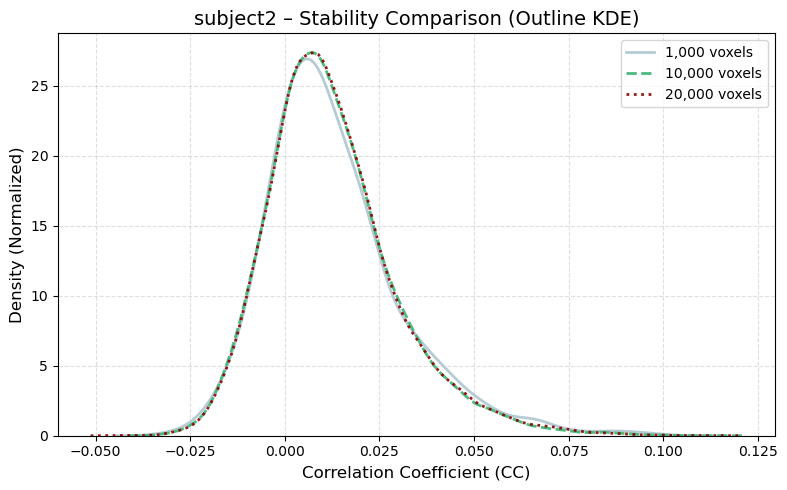


Stability Analysis for subject3
X_train: (25638, 400), Y_train: (25638, 95556)
X_test: (9148, 400), Y_test: (9148, 95556)

--- Evaluating with 1000 randomly selected voxels ---
Subset Size 1000 — Mean CC: 0.0188, Median: 0.0157
Top 1% CC:  0.0847
Top 5% CC:  0.0561

--- Evaluating with 10000 randomly selected voxels ---
Subset Size 10000 — Mean CC: 0.0190, Median: 0.0156
Top 1% CC:  0.0829
Top 5% CC:  0.0573

--- Evaluating with 20000 randomly selected voxels ---
Subset Size 20000 — Mean CC: 0.0188, Median: 0.0154
Top 1% CC:  0.0826
Top 5% CC:  0.0572


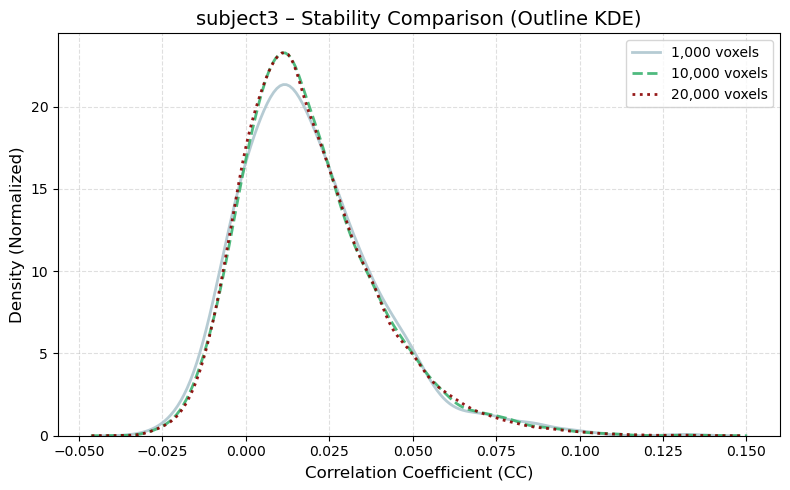

In [21]:
from ridge_utils.ridge import ridge_corr_pred, zs
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os

# === Setup ===
subject_dirs = {
    'subject2': '/ocean/projects/mth240012p/shared/data/subject2',
    'subject3': '/ocean/projects/mth240012p/shared/data/subject3'
}

subset_sizes = [1000, 10000, 20000]

custom_colors = {
    1000: "#aec6cf",   # pale blue
    10000: "#3cb371",  # medium sea green
    20000: "#8b0000"   # dark red
}

# Distinct line styles
custom_linestyles = {
    1000: "solid",
    10000: "dashed",
    20000: "dotted"
}

for subject in ['subject2', 'subject3']:

    print(f"\n======================")
    print(f"Stability Analysis for {subject}")
    print(f"======================")

    # === Load valphas ===
    valphas = np.load(f"valphas_{subject}_glove.npy")

    # === Gather aligned train/test pairs ===
    X_train_list, Y_train_list = [], []
    X_test_list, Y_test_list = [], []

    for story_name, X in train_glove_dic.items():
        y_path = os.path.join(subject_dirs[subject], f"{story_name}.npy")
        if os.path.exists(y_path):
            Y = np.load(y_path)
            if X.shape[0] == Y.shape[0]:
                X_train_list.append(X)
                Y_train_list.append(Y)

    for story_name, X in test_glove_dic.items():
        y_path = os.path.join(subject_dirs[subject], f"{story_name}.npy")
        if os.path.exists(y_path):
            Y = np.load(y_path)
            if X.shape[0] == Y.shape[0]:
                X_test_list.append(X)
                Y_test_list.append(Y)

    if len(X_train_list) == 0 or len(X_test_list) == 0:
        print("No valid train/test stories found.")
        continue

    # === Concatenate ===
    X_train = np.concatenate(X_train_list, axis=0)
    Y_train = np.concatenate(Y_train_list, axis=0)
    X_test = np.concatenate(X_test_list, axis=0)
    Y_test = np.concatenate(Y_test_list, axis=0)

    print(f"X_train: {X_train.shape}, Y_train: {Y_train.shape}")
    print(f"X_test: {X_test.shape}, Y_test: {Y_test.shape}")

    # === Plot KDE curves ===
    plt.figure(figsize=(8, 5))

    for subset_size in subset_sizes:
        print(f"\n--- Evaluating with {subset_size} randomly selected voxels ---")

        np.random.seed(42)
        subset_vox = np.random.choice(Y_train.shape[1], size=subset_size, replace=False)

        # Subset Y and valphas
        Y_train_sub = Y_train[:, subset_vox]
        Y_test_sub = Y_test[:, subset_vox]
        valphas_sub = valphas[subset_vox]

        # Drop zero-variance voxels BEFORE z-scoring
        stds = Y_train_sub.std(axis=0)
        valid_vox = stds > 1e-6
        if not np.all(valid_vox):
            print(f"Dropped {np.sum(~valid_vox)} voxels due to near-zero variance")
            Y_train_sub = Y_train_sub[:, valid_vox]
            Y_test_sub = Y_test_sub[:, valid_vox]
            valphas_sub = valphas_sub[valid_vox]

        # Z-score
        Y_train_z = zs(Y_train_sub)
        Y_test_z = (Y_test_sub - Y_train_sub.mean(0)) / Y_train_sub.std(0)
        X_train_z = zs(X_train)
        X_test_z = (X_test - X_train.mean(0)) / X_train.std(0)

        # Ridge prediction
        corrs = ridge_corr_pred(
            X_train_z, X_test_z,
            Y_train_z, Y_test_z,
            valphas=valphas_sub,
            normalpha=False,
            use_corr=True
        )

        # Report
        print(f"Subset Size {subset_size} — Mean CC: {np.nanmean(corrs):.4f}, Median: {np.nanmedian(corrs):.4f}")
        print(f"Top 1% CC:  {np.nanpercentile(corrs, 99):.4f}")
        print(f"Top 5% CC:  {np.nanpercentile(corrs, 95):.4f}")

        # KDE outline-only plot
        sns.kdeplot(
            corrs[~np.isnan(corrs)],
            label=f"{subset_size:,} voxels",
            color=custom_colors[subset_size],
            linestyle=custom_linestyles[subset_size],
            linewidth=2,
            fill=False,
            alpha=0.9
        )

    plt.title(f"{subject} – Stability Comparison (Outline KDE)", fontsize=14)
    plt.xlabel("Correlation Coefficient (CC)", fontsize=12)
    plt.ylabel("Density (Normalized)", fontsize=12)
    plt.legend()
    plt.grid(True, linestyle='--', alpha=0.4)
    plt.tight_layout()
    plt.show()

